# Corrélations non linéaires

Les corrélations indiquent si deux variables sont linéairement équivalentes. Comment étendre cette notion à des variables liées mais pas de façon linéaire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un exemple

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target
import pandas
df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
df.head()

,X1,X2,X3,X4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


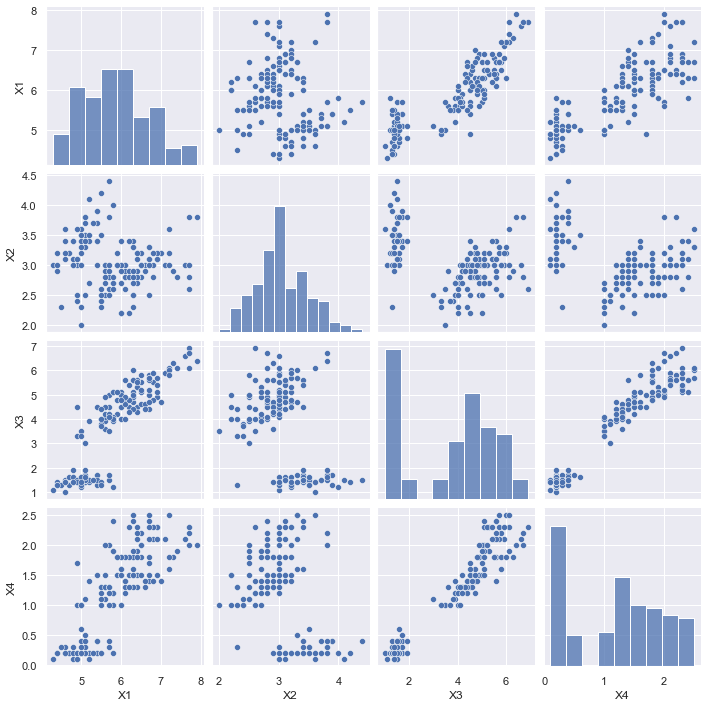

In [4]:
import seaborn as sns
sns.set()
sns.pairplot(df);

Et les corrélations :

In [5]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.117570,0.871754,0.817941
X2,-0.117570,1.000000,-0.428440,-0.366126
X3,0.871754,-0.428440,1.000000,0.962865
X4,0.817941,-0.366126,0.962865,1.000000


## Un peu de théorie

Le coefficient de [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) de Pearson est calculé comme suit :

$$cor(X_i, X_j) = \frac{cov(X_i, Y_i)}{\sigma(X_i)\sigma(X_j)}$$

Lorsque les variables sont centrées $\mathbb{E}X_i=\mathbb{E}X_j=0$, cette formule devient :

$$cor(X_i, X_j) = \frac{\mathbb{E}(X_i X_j)}{\sqrt{\mathbb{E}X_i^2 \mathbb{E}X_j^2}}$$

Lorsque les variables sont réduites $\mathbb{E}X_i^2=\mathbb{E}X_j^2=1$, cette formule devient $cor(X_i, X_j) = \mathbb{E}(X_i X_j)$. Admettons maintenant que l'on cherche à trouver le coefficient $\alpha_{ij}$ qui minimise la variance du bruit $\epsilon_{ij}$ :

$$X_j = \alpha_{ij}X_i + \epsilon_{ij}$$

Le coefficient $\alpha_{ij}$ est le résultat d'une régression linéaire qui minimise $\mathbb{E}(X_j - \alpha_{ij}X_i)^2$. Si les variables $X_i$, $X_j$ sont centrées et réduites : $\alpha_{ij}^* = \mathbb{E}(X_i X_j) = cor(X_i, X_j)$. On étend cette définition dans le cas d'une fonction paramétrable $f$ : $f(\omega, X) \rightarrow \mathbb{R}$ et d'une régression non linéaire. On suppose que les paramètres $\omega^*$ minimisent la quantité $\min_\omega (X_j  - f(\omega, X_i))^2$. On écrit alors $X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij}$ et on choisit $\alpha_{ij}$ de telle sorte que $\mathbb{E}\left(\frac{f(\omega^*, X_i)^2}{\alpha_{ij}^2}\right) = 1$. On définit la corrélation non linéaire au sens de $f$ : 

$$cor^f(X_i, X_j) = \sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}$$

On vérifie que ce coefficient est compris entre [0, 1]. Il est positif de manière évidente. Il est également inférieur à 1, si cela n'était pas le cas, nous pourrions construire une fonction $f(\omega^*, X)+c$ qui est une meilleur solution pour le programme de minimisation. Ce nombre ressemble à une corrélation à ceci près qu'elle ne peut être négative.

## Vérifications

Tout d'abord le cas linéaire :

In [6]:
from sklearn.preprocessing import scale
import numpy

def correlation_etendue(df, model, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            mod = model(**params)
            xj = df[:, j]
            mod.fit(xi, xj)
            v = mod.predict(xi)
            c = numpy.std(v)
            cor.iloc[i,j] = c
    return cor

from sklearn.linear_model import LinearRegression
cor = correlation_etendue(df, LinearRegression, fit_intercept=False)
cor

,X1,X2,X3,X4
X1,1.000000,0.117570,0.871754,0.817941
X2,0.117570,1.000000,0.428440,0.366126
X3,0.871754,0.428440,1.000000,0.962865
X4,0.817941,0.366126,0.962865,1.000000


On affiche à nouveau les corrélations qui sont identiques au signe près.

In [7]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.117570,0.871754,0.817941
X2,-0.117570,1.000000,-0.428440,-0.366126
X3,0.871754,-0.428440,1.000000,0.962865
X4,0.817941,-0.366126,0.962865,1.000000


Et le cas non linéaire :

In [8]:
from sklearn.tree import DecisionTreeRegressor
cor = correlation_etendue(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,1.000000,0.544441,0.915847,0.879583
X2,0.418274,1.000000,0.591839,0.539524
X3,0.937056,0.789727,1.000000,0.978332
X4,0.846161,0.761652,0.980005,1.000000


In [9]:
from sklearn.ensemble import RandomForestRegressor
cor = correlation_etendue(df, RandomForestRegressor, n_estimators=10)
cor

,X1,X2,X3,X4
X1,0.995813,0.584372,0.903653,0.890281
X2,0.457135,0.988750,0.586551,0.570621
X3,0.912678,0.792242,0.998989,0.980065
X4,0.851378,0.783762,0.984059,1.001596


## Overfitting

Ces chiffres sont beaucoup trop optimistes. Les modèles de machine learning peuvent tout à fait faire de l'overfitting. Il faut améliorer la fonction en divisant en apprentissage et test plusieurs fois. Il faut également tenir compte de l'erreur de prédiction. On rappelle que : 

$$X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij} = cor^f(X_i, X_j) \frac{f(\omega^*, X_i)}{\sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}} + \epsilon_{ij}$$

Or $\mathbb{E}(X_j^2)=1$ et on suppose que les bruits ne sont pas corrélées linéairement aux $f(\omega^*, X_i)$. On en déduit que $cor^f(X_i, X_j) = \sqrt{ 1 - \mathbb{E}\epsilon_{ij}^2}$.

In [10]:
from sklearn.model_selection import train_test_split
import numpy

def correlation_cross_val(df, model, draws=5, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            for k in range(0, draws):
                xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, test_size=0.5)
                mod = model(**params)            
                mod.fit(xi_train, xj_train)
                v = mod.predict(xi_test)
                c = (1 - numpy.var(v - xj_test))
                mem.append(max(c, 0) **0.5)
            cor.iloc[i,j] = sum(mem) / len(mem)
    return cor

cor = correlation_cross_val(df, LinearRegression, fit_intercept=False, draws=20)
cor

,X1,X2,X3,X4
X1,1.000000,0.223866,0.873505,0.817221
X2,0.136720,1.000000,0.389141,0.391370
X3,0.866435,0.348342,1.000000,0.962642
X4,0.821551,0.367914,0.961689,1.000000


In [11]:
cor = correlation_cross_val(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,0.998542,0.034959,0.860007,0.759291
X2,0.000000,0.996616,0.258970,0.043281
X3,0.862716,0.465071,0.999257,0.946699
X4,0.702251,0.647392,0.969055,0.999707


In [12]:
cor = correlation_cross_val(df, RandomForestRegressor, n_estimators=10)
cor

,X1,X2,X3,X4
X1,0.998797,0.000000,0.863563,0.788530
X2,0.000000,0.992557,0.359637,0.379311
X3,0.881162,0.519797,0.999182,0.956176
X4,0.745702,0.654169,0.967190,0.999446


Les résultats sont assez fluctuants lorsque les données sont mal corrélées. On remarque également que la matrice n'est plus nécessairement symmétrique.

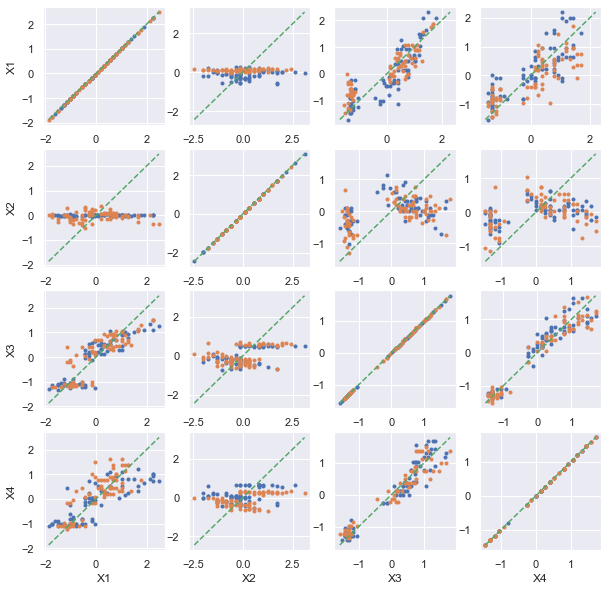

In [13]:
import matplotlib.pyplot as plt

def pairplot_cross_val(data, model=None, ax=None, **params):
    if ax is None:
        fig, ax = plt.subplots(data.shape[1], data.shape[1], figsize=params.get('figsize', (10,10)))
    if 'figsize' in params:
        del params["figsize"]
    if model is None:
        from sklearn.linear_model import LinearRegression
        model = LinearRegression
    
    df = scale(data)
    cor = numpy.corrcoef(df.T)
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, test_size=0.5)
            mod = model(**params)            
            mod.fit(xi_train, xj_train)
            v = mod.predict(xi_test)
            mod = model(**params)            
            mod.fit(xi_test, xj_test)
            v2 = mod.predict(xi_train)
            ax[i,j].plot(xj_test, v, ".")
            ax[i,j].plot(xj_train, v2, ".")
            if j == 0:
                ax[i,j].set_ylabel(data.columns[i])
            if i == data.shape[1]-1:
                ax[i,j].set_xlabel(data.columns[j])
            mi = min(min(xj_test), min(v), min(xj_train), min(v2))
            ma = max(max(xj_test), max(v), max(xj_train), max(v2))
            ax[i,j].plot([mi, ma], [mi, ma], "--")
    return ax
            
ax = pairplot_cross_val(df)
ax;

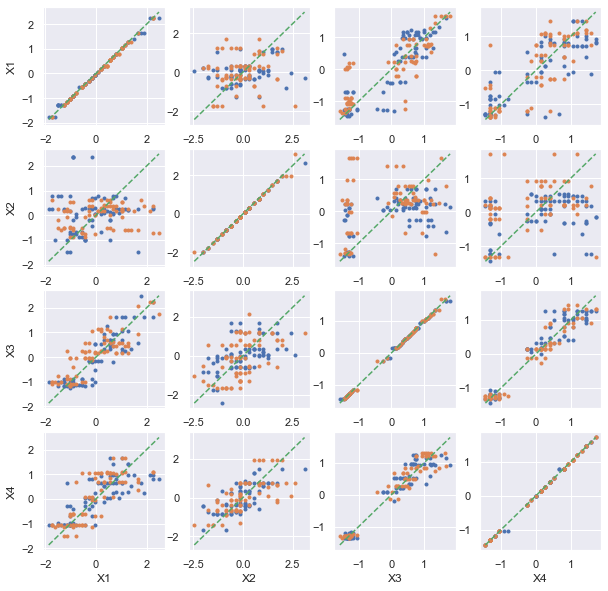

In [14]:
ax = pairplot_cross_val(df, model=DecisionTreeRegressor)
ax;

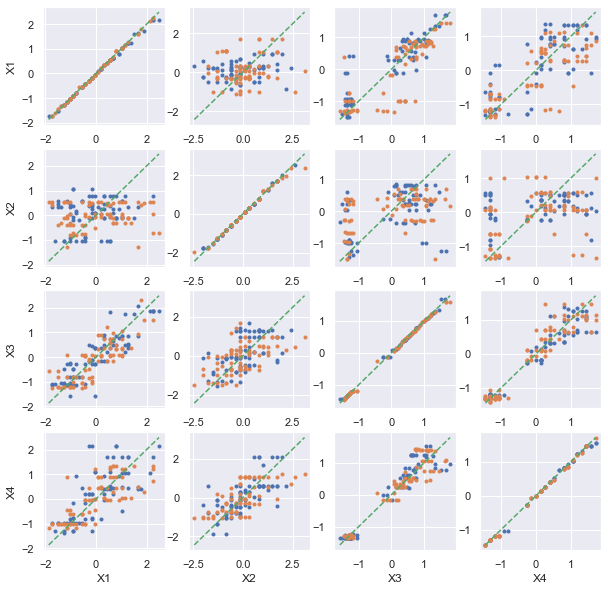

In [15]:
ax = pairplot_cross_val(df, model=RandomForestRegressor, n_estimators=10)
ax;

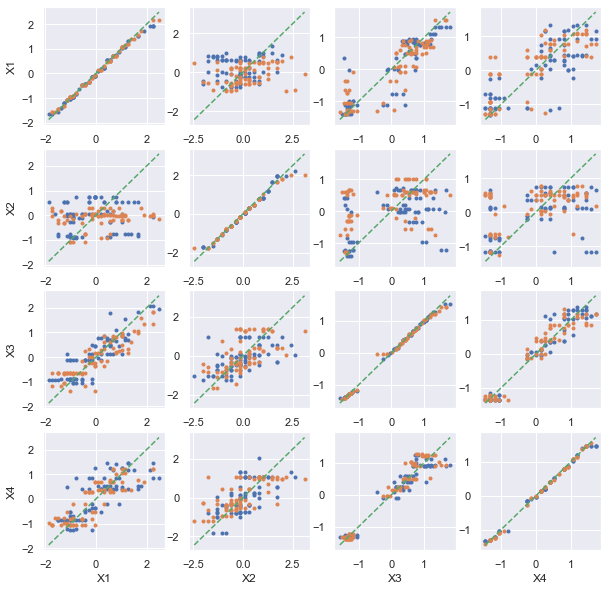

In [16]:
from sklearn.neighbors import KNeighborsRegressor
ax = pairplot_cross_val(df, model=KNeighborsRegressor)
ax;

## Corrélations de variables catégorielles

C'est le problème épineux si on se restreint au linéaire. Cela n'a pas trop de sens d'affecter une valeur à chaque catégorie et la corrélation de deux variables binaires (des modalités) est toujours étrange car il n'y a que deux valeurs possibles.

$$cov(X,Y) = \mathbb{E}\left[(X - \mathbb{E}X)(Y - \mathbb{E}Y)\right] = \mathbb{E}(XY) - \mathbb{E}X\mathbb{E}Y = \mathbb{P}(X=1 \, et \, Y=1) - \mathbb{E}X\mathbb{E}Y$$

Dans le cas de variables binaires générées de modalités de la même variables catégorielles, le premier terme est toujours nul puisque les modalités sont exclusives et la corrélation est toujours négative.

In [17]:
import random
ex = numpy.zeros((100, 2))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [18]:
numpy.corrcoef(ex.T)

array([[ 1., -1.],
       [-1.,  1.]])

In [19]:
import random
ex = numpy.zeros((100, 3))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]
numpy.corrcoef(ex.T)

array([[ 1.        , -0.51449576, -0.51449576],
       [-0.51449576,  1.        , -0.47058824],
       [-0.51449576, -0.47058824,  1.        ]])

Supposons maintenant que nous avons deux variables catégorielles très proches :

* $X_1$ est une couleur rouge, bleu, gris.
* $X_2$ est une nuance rose, orange, cyan, magenta, blanc noir.

In [20]:
c1 = ["rouge", "bleu", "gris"]
c2 = ["rose" ,"orange" ,"cyan" ,"magenta", "blanc", "noir"]
ind = [random.randint(0, 2) for i in range(0, 100)]
x1 = [c1[i] for i in ind]
x2 = [c2[i*2 + random.randint(0,1)] for i in ind]
df = pandas.DataFrame(dict(X1=x1, X2=x2))
df.head()

,X1,X2
0,gris,noir
1,bleu,magenta
2,rouge,orange
3,rouge,rose
4,rouge,orange


On peut évidemment transformer en entier.

In [21]:
dummies = pandas.get_dummies(df)
dummies.head()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,0,0,1,0


In [22]:
dummies.corr()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
X1_bleu,1.000000,-0.610771,-0.478200,-0.451934,0.642256,0.569146,-0.314239,-0.328945,-0.299166
X1_gris,-0.610771,1.000000,-0.403335,0.739940,-0.392271,-0.347618,0.514496,-0.277447,-0.252330
X1_rouge,-0.478200,-0.403335,1.000000,-0.298444,-0.307127,-0.272166,-0.207514,0.687881,0.625608
X2_blanc,-0.451934,0.739940,-0.298444,1.000000,-0.290257,-0.257216,-0.196116,-0.205294,-0.186709
X2_cyan,0.642256,-0.392271,-0.307127,-0.290257,1.000000,-0.264699,-0.201822,-0.211266,-0.192141
X2_magenta,0.569146,-0.347618,-0.272166,-0.257216,-0.264699,1.000000,-0.178848,-0.187217,-0.170269
X2_noir,-0.314239,0.514496,-0.207514,-0.196116,-0.201822,-0.178848,1.000000,-0.142745,-0.129823
X2_orange,-0.328945,-0.277447,0.687881,-0.205294,-0.211266,-0.187217,-0.142745,1.000000,-0.135898
X2_rose,-0.299166,-0.252330,0.625608,-0.186709,-0.192141,-0.170269,-0.129823,-0.135898,1.000000


Ca ne dit pas grand-chose.

In [23]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["X1e"] = enc.fit_transform(df["X1"])
df["X2e"] = enc.fit_transform(df["X2"])
df.head()

,X1,X2,X1e,X2e
0,gris,noir,1,3
1,bleu,magenta,0,2
2,rouge,orange,2,4
3,rouge,rose,2,5
4,rouge,orange,2,4


In [24]:
df.corr()

,X1e,X2e
X1e,1.000000,0.630987
X2e,0.630987,1.000000


Ca ne veut toujours pas dire grand-chose. Et si on change la première colonne en permutant les lables :

In [25]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
df.head()

,X1,X2,X1e,X2e
0,gris,noir,2,3
1,bleu,magenta,1,2
2,rouge,orange,0,4
3,rouge,rose,0,5
4,rouge,orange,0,4


In [26]:
df.corr()

,X1e,X2e
X1e,1.000000,-0.731577
X2e,-0.731577,1.000000


La corrélation linéaire sur des variables catégorielles n'a pas de sens. Essayons avec un arbre de décision. C'est le modèle adéquat pour ce type de valeur discrètes :

In [27]:
cor = correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)
cor

,X1e,X2e
X1e,1.0,0.817775
X2e,1.0,1.000000


Et si on permute le premier label :

In [28]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)

,X1e,X2e
X1e,1.0,0.801007
X2e,1.0,1.000000


Même résultat qui s'interprète de la sorte :

* La variable *X1e* se déduit de *X2e* (car *cor(X2e, X1e) = 1*).
* La variable *X2e* et fortement lié à *X2e*.

La valeur numérique choisie pour représente la variable catégorielle n'a pas d'impact sur les résultats.

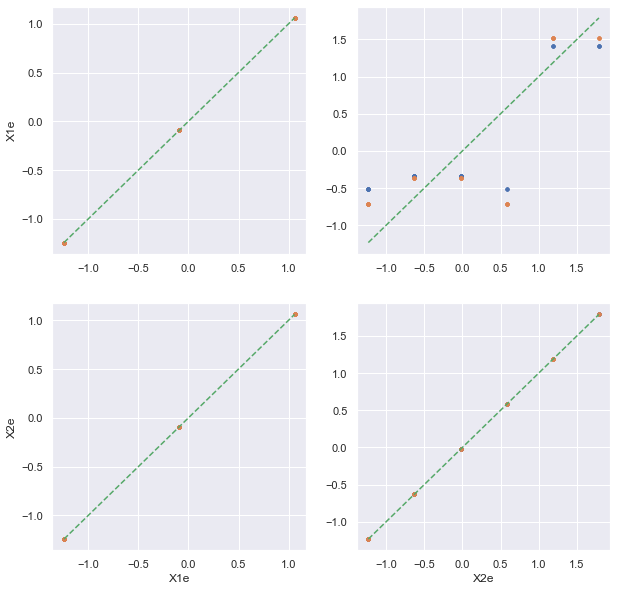

In [29]:
ax = pairplot_cross_val(df[["X1e", "X2e"]], model=DecisionTreeRegressor)
ax;

Et sur un jeu de données plus complet.

In [30]:
from sklearn.datasets import load_boston
df = load_boston()
df = pandas.DataFrame(df.data, columns=df.feature_names)
df.head()

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [31]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


On dessine les 5 premières variables. On voit que la variable CHAS est binaire.

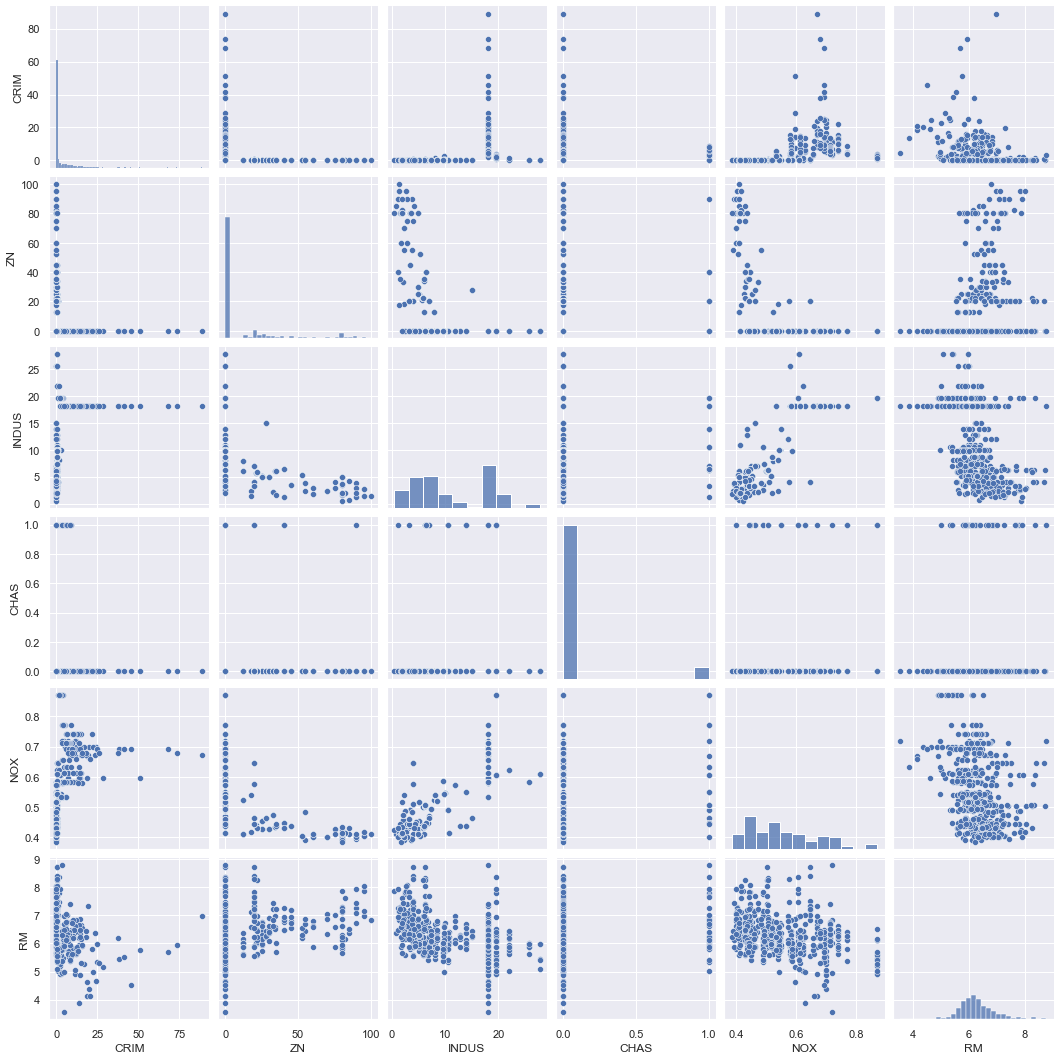

In [32]:
sns.pairplot(df[df.columns[:6]]);

In [33]:
correlation_cross_val(df, DecisionTreeRegressor)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,0.950599,0.259153,0.357622,0.000000,0.560401,0.000000,0.159142,0.134634,0.939584,0.797644,0.000000,0.000000,0.047763
ZN,0.220429,0.999324,0.606898,0.029739,0.560005,0.318082,0.594242,0.724110,0.365125,0.401491,0.517081,0.056507,0.453555
INDUS,0.565182,0.819467,0.999941,0.247167,0.903982,0.443830,0.749621,0.909947,0.996176,0.986208,0.911224,0.386504,0.616603
CHAS,0.356546,0.138910,0.154005,1.000000,0.048117,0.045914,0.037492,0.157614,0.046492,0.087877,0.141326,0.203032,0.113786
NOX,0.564280,0.896597,0.966202,0.223939,0.999987,0.416178,0.797719,0.890117,0.955381,0.962870,0.884712,0.590098,0.644107
RM,0.078798,0.000000,0.000000,0.000000,0.000000,0.998216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGE,0.000000,0.162514,0.167802,0.000000,0.480287,0.000000,0.999933,0.505532,0.000000,0.000000,0.000000,0.000000,0.067760
DIS,0.085168,0.579106,0.590573,0.000000,0.683574,0.000000,0.629632,0.999345,0.000000,0.000000,0.000000,0.000000,0.000000
RAD,0.630197,0.384235,0.687372,0.181781,0.632656,0.393590,0.479372,0.587830,1.000000,0.931249,0.585252,0.489242,0.473019
TAX,0.574762,0.666681,0.933695,0.156199,0.881701,0.207245,0.738575,0.850848,0.992375,0.999952,0.873809,0.504879,0.579704


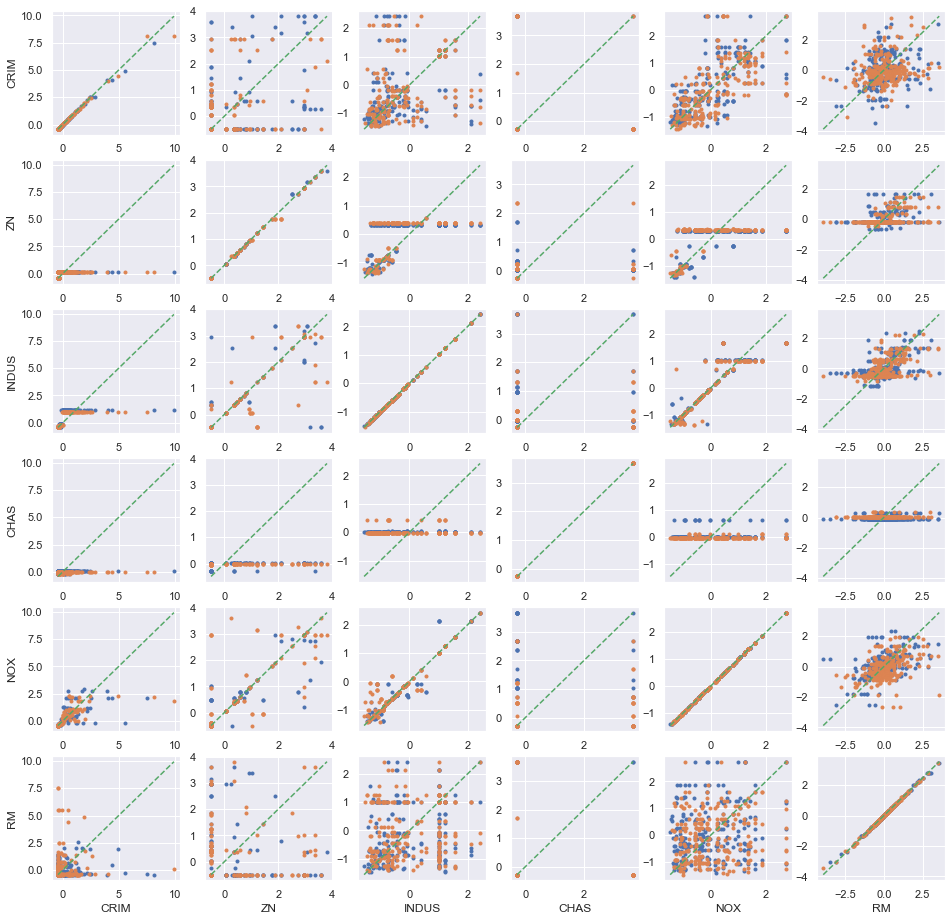

In [34]:
pairplot_cross_val(df[df.columns[:6]], model=DecisionTreeRegressor, figsize=(16,16));

On regarde en pariculier les variables TAX, RAD, PTRATIO.

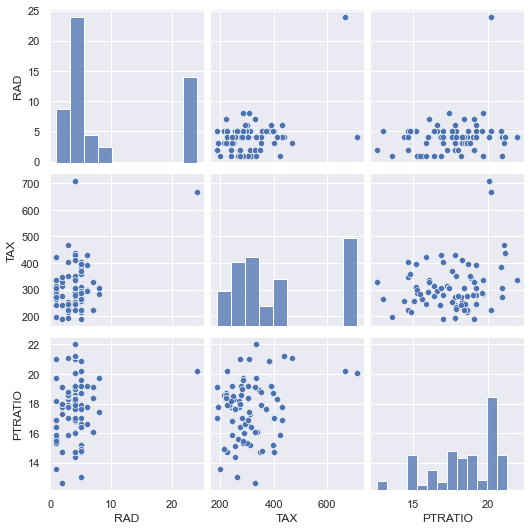

In [35]:
sns.pairplot(df[["RAD", "TAX", "PTRATIO"]]);

In [36]:
df[["RAD", "TAX", "PTRATIO"]].corr()

,RAD,TAX,PTRATIO
RAD,1.000000,0.910228,0.464741
TAX,0.910228,1.000000,0.460853
PTRATIO,0.464741,0.460853,1.000000


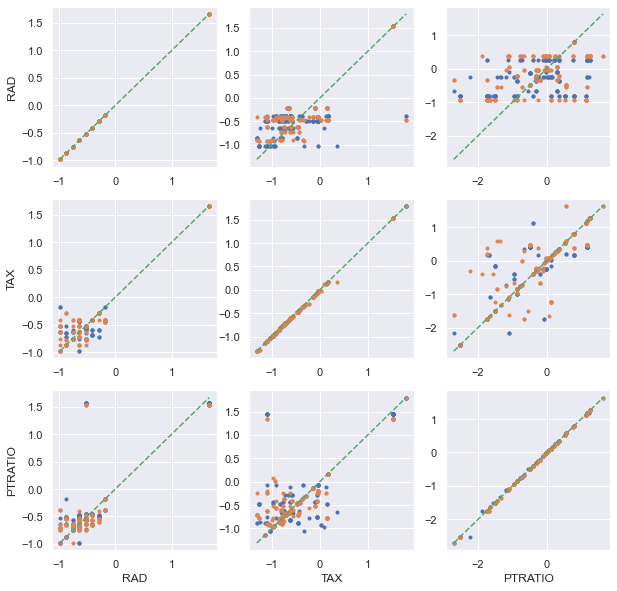

In [37]:
pairplot_cross_val(df[["RAD", "TAX", "PTRATIO"]], model=DecisionTreeRegressor);

In [38]:
correlation_cross_val(df[["RAD", "TAX", "PTRATIO"]], DecisionTreeRegressor)

,RAD,TAX,PTRATIO
RAD,1.000000,0.925683,0.628917
TAX,0.990729,0.999932,0.876749
PTRATIO,0.946408,0.902800,0.999801


Les variables sont toutes trois liées de façon non linéaire.

## Maximal information coefficient

Cette approche est plutôt pragmatique mais peut se révéler coûteuse en terme de calculs. Elle permet aussi de comprendre qu'un coefficient de corrélation dépend des hypothèses qu'on choisi pour les données. On peut toujours construire un coefficient de corrélation qui soit égal à 1 mais il correspond à toujours à un phénomène qu'on souhaite étudier. La corrélation linéaire recherche des relations linéaires. On peut chercher une relation polynomiale. Les arbres de décision recherche une corrélation construite à partir de fonction en escalier. Plus la relation a de degré de liberté, plus le coefficient a de chance de tendre vers 1, moins il a de chance d'être aussi élevé sur de nouvelles données.

Cela permet néanmoins de mieux comprendre les avantages et les inconvénients de métriques du type [MIC](https://en.wikipedia.org/wiki/Maximal_information_coefficient) ou *Maximal information coefficient*. Plus de détails sont disponibles dans cet article : [Equitability, mutual information, and the maximal information coefficient](https://arxiv.org/abs/1301.7745v1). Le module [minepy](http://minepy.readthedocs.io/en/latest/python.html) implémente cette métrique ainsi que d'autres qui poursuivent le même objectif. L'information mutuelle est définie comme ceci pour deux variables discrètes :

$$MI(X,Y) = \sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}}p(x,y)\ln_2\frac{p(x,y)}{p(x)p(y)}$$

La fonction $p(x,y)$ définit la distribution conjointe des deux variables, $p(x)$, $p(y)$ les deux probabilités marginales. Il existe une extension pour les variables continues :

$$MIC(X,Y) = \int_{x\in\mathcal{X}}\in_{y\in\mathcal{Y}}p(x,y)\ln_2\frac{p(x,y)}{p(x)p(y)}dxdy$$

Une façon de calculer une approximation du coefficient $MIC(x,y)$ est de discrétiser les deux variables $X$ et $Y$ ce qu'on fait en appliquant un algorithme similaire à celui utilisé pour construire un arbre de décision à ceci près que qu'il n'y a qu'une seule variable et que la variable à prédire est elle-même.

L'information mutuelle est inspiré de la distance de [Kullback-Leiber](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) qui est une distance entre deux probabilités qui sont ici la disribution du couple $(X,Y)$ et la distribution que ce couple aurait si les deux variables étaient indépendantes, c'est à dire le produit de leur distribution.

In [39]:
%matplotlib inline

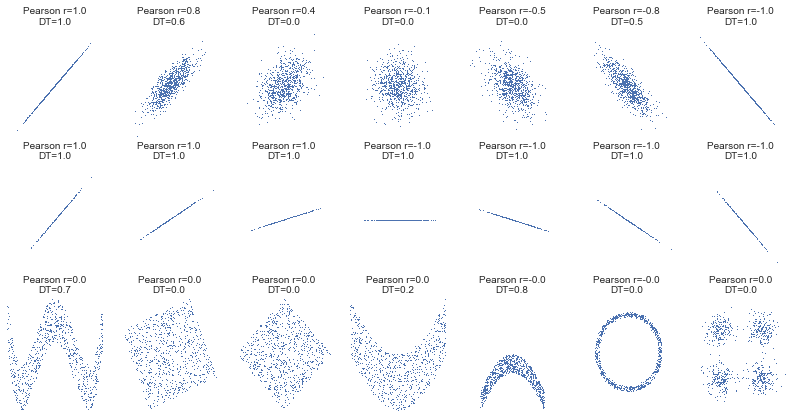

In [40]:
import numpy as np
import matplotlib.pyplot as plt


rs = np.random.RandomState(seed=0)

def mysubplot(x, y, numRows, numCols, plotNum,
              xlim=(-4, 4), ylim=(-4, 4)):

    r = np.around(np.corrcoef(x, y)[0, 1], 1)
    
    # début ajout
    df = pandas.DataFrame(dict(x=x, y=y))
    cor = correlation_cross_val(df, DecisionTreeRegressor)
    dt = max(cor.iloc[1,0], cor.iloc[0,1])
    
    ax = plt.subplot(numRows, numCols, plotNum,
                     xlim=xlim, ylim=ylim)
    ax.set_title('Pearson r=%.1f\nDT=%.1f' % (r, dt),fontsize=10)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.plot(x, y, ',')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def rotation(xy, t):
    return np.dot(xy, [[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

def mvnormal(n=1000):
    cors = [1.0, 0.8, 0.4, 0.0, -0.4, -0.8, -1.0]
    for i, cor in enumerate(cors):
        cov = [[1, cor],[cor, 1]]
        xy = rs.multivariate_normal([0, 0], cov, n)
        mysubplot(xy[:, 0], xy[:, 1], 3, 7, i+1)

def rotnormal(n=1000):
    ts = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/2-np.pi/6,
          np.pi/2-np.pi/12, np.pi/2]
    cov = [[1, 1],[1, 1]]
    xy = rs.multivariate_normal([0, 0], cov, n)
    for i, t in enumerate(ts):
        xy_r = rotation(xy, t)
        mysubplot(xy_r[:, 0], xy_r[:, 1], 3, 7, i+8)

def others(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4*(x**2-0.5)**2 + rs.uniform(-1, 1, n)/3
    mysubplot(x, y, 3, 7, 15, (-1, 1), (-1/3, 1+1/3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2+np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 16, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi/8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 17, (-lim, lim), (-lim, lim))

    y = 2*x**2 + rs.uniform(-1, 1, n)
    mysubplot(x, y, 3, 7, 18, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.5, n)) * \
        np.array([-1, 1])[rs.randint(0, 1, size=n)]
    mysubplot(x, y, 3, 7, 19, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1/8, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1/8, n)
    mysubplot(x, y, 3, 7, 20, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], int(n/4))
    xy2 = np.random.multivariate_normal([-3, 3], [[1, 0], [0, 1]], int(n/4))
    xy3 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], int(n/4))
    xy4 = np.random.multivariate_normal([3, -3], [[1, 0], [0, 1]], int(n/4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 21, (-7, 7), (-7, 7))

plt.figure(figsize=(14,7))
mvnormal(n=800)
rotnormal(n=200)
others(n=800)
# plt.tight_layout()
# plt.show()